This notebook illustrates the use of convolutional networks for a multiclass classification over the MNIST dataset. This notebook is based on the PyTorch MNIST example: https://github.com/pytorch/examples/tree/master/mnist

The MNIST dataset contains handwritten digits like these:

 ![MNIST samples](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

Each digit is 28x28 pixels and is labeled with the digit it contains, e.g. this is labeled with a "0":

<img src="http://neuralnetworksanddeeplearning.com/images/mnist_complete_zero.png" width="200">


In [1]:
!pip install pillow==5.4.1
!pip install matplotlib
!pip install scikit-learn
!pip install torch
!pip install torchvision

    100% |████████████████████████████████| 2.0MB 13.5MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
  [PIL]
You must restart the runtime in order to use newly installed versions.
    100% |████████████████████████████████| 591.8MB 27kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x61e64000 @  0x7f31fe8302a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 4.6MB/s 


In [0]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

Let's define our model. The standard PyTorch way of doing so is to create a class inheriting from `torch.nn.Module`.

In its `__init__` method, we create the layers we are going to need and store them as member variables.

In its `forward` method we implement the forward pass computation, making use of the layers we created in the constructor.

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Now let's create a function that trains over an epoch. Every N steps we will `print` the progress. As input to the training, we are going to assume we receive an iterator to the training batches.

Note that, as we are facing a multiclass classification problem, we use the **negative log likelihood** (NLL) as loss function.

In [0]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    losses = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return losses

And now let's create a similar function but to evaluate the performance of the model over a validation data set:

In [0]:
def validate(model, device, loader):
    
    model.eval()  # let's put the model in evaluation mode

    validation_loss = 0
    correct = 0
    
    with torch.no_grad():  # we don't need gradient computation at all
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            validation_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss /= len(loader.dataset)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(loader.dataset),
        100. * correct / len(loader.dataset)))
    
    return validation_loss


Now, we will use the dataset from `torchvision` to load MNIST and the PyTorch loaders to get iterators to the batches, for both training and validation data.

Note that we apply a linear transformation to normalize the data.

In [6]:
train_batch_size = 128

mnist_mean = 0.1307
mnist_stddev = 0.3081
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data',
                   train=True,
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mnist_mean,), (mnist_stddev,))
                   ])),
    batch_size=train_batch_size,
    shuffle=True)

valid_batch_size = 1000
valid_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data',
                   train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mnist_mean,), (mnist_stddev,))
                   ])),
    batch_size=valid_batch_size,
    shuffle=True)

Processing...
Done!


And finally, let's create the network, move it to the GPU and iterate through some epochs of training:

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309556
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.679794
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.269344
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.289576
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.295047
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.221781

Validation set: Average loss: 0.1543, Accuracy: 9571/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.158339
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.194528
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.073762
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.060525
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.122056
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.104511

Validation set: Average loss: 0.0885, Accuracy: 9731/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.102851
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.065147
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.076824
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.075484
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.075687
Train Epoch: 3 [51200/60000 (85

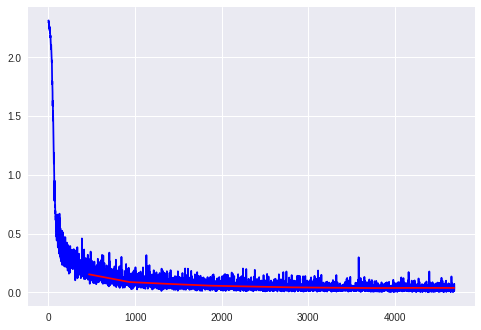

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

train_losses = []
valid_losses = []
valid_x = []
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    epoch_losses = train(80, model, device, train_loader, optimizer, epoch)
    train_losses.extend(epoch_losses)
    valid_loss = validate(model, device, valid_loader)
    valid_losses.append([valid_loss])
    valid_x.append(len(train_losses) - 1)

plt.gcf().clear()
plt.plot(train_losses, 'b-')
plt.plot(valid_x, valid_losses, 'r-')
plt.show()